![](https://images.aicrowd.com/raw_images/challenges/banner_file/1005/f32303cdf2b8a796b74c.jpg)

<h2><center>Getting Started with Language Translation</center></h2>
<h2><center> Using Seq2Seq Model </center></h2>

- In this puzzle, the problem statement is quite simple.  We need to build a translator that should be able to translate to English from a fake language. There are many ways to build a machine translator. In this notebook, we'll use a **seq2seq model**.

- This notebook is inspired by [NLP from: Translation with a Seq2Seq and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

- A generalized architecture of machine translator we are going to build in this notebook:
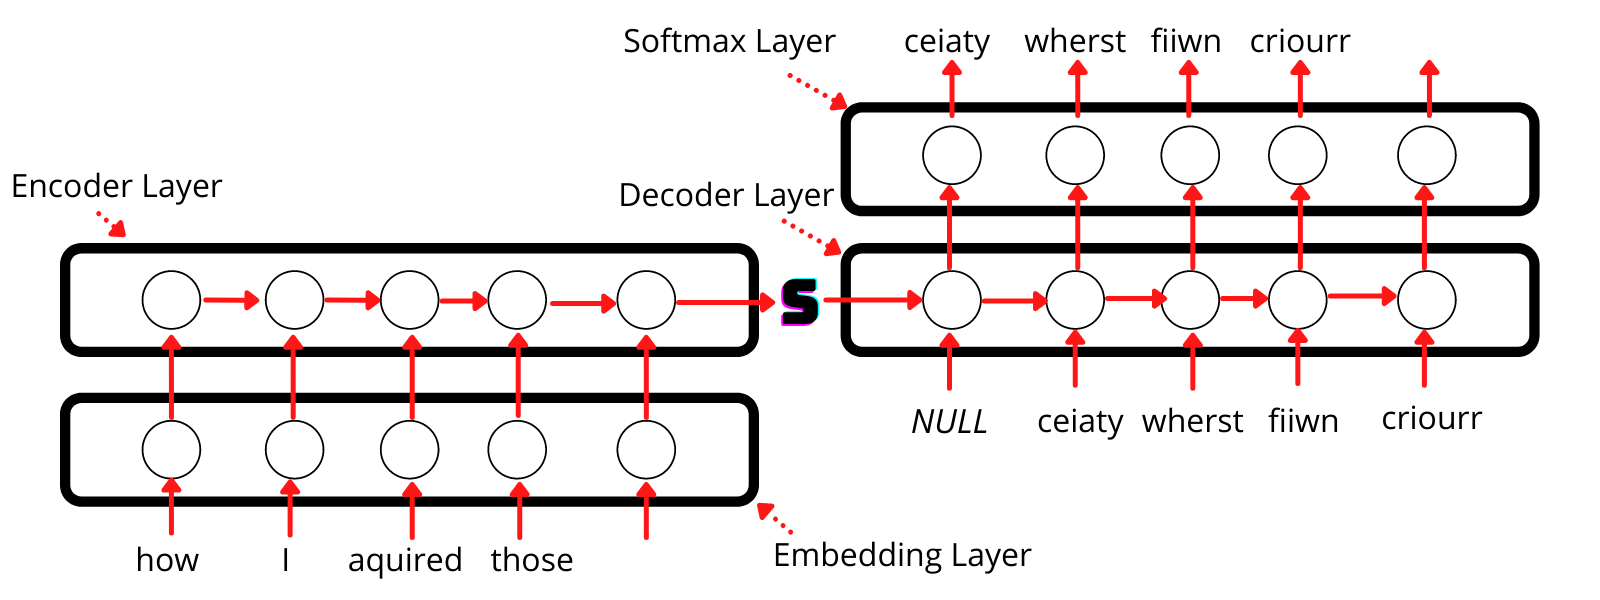



## Download the files 💾¶ using AIcrowd CLI
We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.

In [1]:
%%capture
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/1qeOWxKEVVQ6hOD1AweWxJgv5tjeYws3G9bDzq1qz80
API Key valid
Saved API Key successfully!


In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c lingua-franca-translation -o data

sample_submission.csv:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/437k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

## Importing Libraries

In [4]:
%%capture
!pip install torchtext==0.6.0 --quiet

In [5]:
import os
import numpy as np
import pandas as pd
import spacy
import random

import torch
import torch.nn as nn
import torch.optim as optim
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from torchtext.data import Field, BucketIterator, TabularDataset

from torchtext.data.metrics import bleu_score
from pprint import pprint
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Understanding Dataset

In [6]:
train_df = pd.read_csv("data/train.csv")

In [7]:
test_df = pd.read_csv("data/test.csv")

In [8]:
sample = pd.read_csv("data/sample_submission.csv")

In [9]:
train_df.head()

id  ...                                            english
0  31989  ...               upon this ladder one of them mounted
1  29884  ...  and solicited at the court of Augustus to be p...
2  26126  ...                                 but how am I sunk!
3  44183  ...      the Yahoos draw home the sheaves in carriages
4  19108  ...          and placed his hated hands before my eyes

[5 rows x 3 columns]

In [57]:
train_df.crowdtalk[0]

'wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts'

In [10]:
test_df.head()

id                                          crowdtalk
0  27226  treuns schleangly throuys praests qeipp cyclui...
1  31034  feosch treuns schleangly gliath spluiey gheuck...
2  35270  scraocs knaedly squiend sriohl clield whaioght...
3  23380  sqaups schlioncy yoik gnoirk cziourk schnaunk ...
4  92117  schlioncy yoik psycheiancy mcountz pously mcna...

In [11]:
english = train_df.english.values
crowdtalk = train_df.crowdtalk.values

In [12]:
print("Length of english sentence:", len(english))
print("Length of fake sentence:", len(crowdtalk))

Length of english sentence: 11955
Length of fake sentence: 11955


In [13]:
train_df.isnull().sum()

id           0
crowdtalk    0
english      0
dtype: int64

### Findings:
Here, We've 19286 samples of fake and english sentences. We can see that we need to build a model that can translate the fake language to English. So, going ahead we need to prepare data to feed the translator model.

## Data Preparation:
We'll focus on two things:

- Tokenization: Tokenization is a way of separating a piece of text into smaller units called tokens.

- Encoding: We'll encode the sentence with the help of tokenizer and pad sequence(It helps to keep the length constant).

Note:
---
- We will use Pytorch Torchtext. From Torchtext, we will use Fields, TabularDataset, BucketIterator to do all the heavy preprocessing for NLP tasks, such as numericalizing, padding, building vocabulary, which saves us a lot of time to focus on actually training the models!

- Since the crowdtalk language is derived from English we will use `Spacy's English Tokenizer` for both English & Crowdtalk sentences


In [14]:
nlp = English()
tokenizer = Tokenizer(nlp.vocab)

def tokens(text):
  return [token.text for token in tokenizer(text)]

In [15]:
sample_text = "I am in love with Machine Translation."
print(tokens(sample_text))

['I', 'am', 'in', 'love', 'with', 'Machine', 'Translation.']


In [16]:
english = Field(sequential=True, use_vocab=True, tokenize=tokens, lower=True)
crowdtalk = Field(sequential=True, use_vocab=True, tokenize=tokens, lower=True)

In [17]:
train, test = train_test_split(train_df, test_size=0.25)

In [18]:
# Get train, test data to json and csv format which can be read by torchtext
train.to_json("train.json", orient="records", lines=True)
test.to_json("test.json", orient="records", lines=True)

In [19]:
fields = {"english": ("eng", english), "crowdtalk": ("crowd", crowdtalk)}

In [20]:
train_data, test_data = TabularDataset.splits(
    path="", train="train.json", test="test.json", format="json", fields=fields
)

In [21]:
english.build_vocab(train_data, max_size=10000, min_freq=2)
crowdtalk.build_vocab(train_data, max_size=10000, min_freq=2)

In [22]:
e = list(english.vocab.__dict__.values())
for i in e:
  print(i)

Counter({'the': 4960, 'of': 3289, 'and': 3052, 'to': 2725, 'i': 2540, 'a': 1849, 'my': 1542, 'in': 1534, 'was': 1131, 'that': 1052, 'me': 837, 'with': 792, 'his': 684, 'had': 682, 'as': 677, 'he': 622, 'for': 621, 'it': 611, 'which': 605, 'by': 596, 'but': 576, 'not': 527, 'be': 499, 'they': 445, 'on': 443, 'at': 440, 'their': 429, 'from': 414, 'this': 399, 'were': 387, 'have': 346, 'so': 313, 'is': 306, 'or': 297, 'her': 288, 'all': 280, 'would': 278, 'could': 272, 'when': 270, 'an': 263, 'them': 258, 'you': 251, 'upon': 246, 'some': 232, 'one': 230, 'him': 228, 'are': 215, 'who': 214, 'into': 205, 'we': 197, 'great': 182, 'our': 174, 'been': 168, 'very': 167, 'should': 162, 'no': 162, 'any': 158, 'more': 156, 'she': 156, 'these': 152, 'those': 151, 'your': 150, 'made': 150, 'than': 148, 'only': 144, 'if': 143, 'other': 143, 'about': 140, 'might': 135, 'two': 133, 'out': 131, 'what': 125, 'up': 125, 'own': 124, 'most': 124, 'then': 124, 'much': 123, 'being': 122, 'every': 120, 'before

In [23]:
word_2_idx = dict(e[3])
idx_2_word = {}
for k,v in word_2_idx.items():
  idx_2_word[v] = k

In [24]:
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data), batch_size=32, device=device
)

In [25]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(train_data[5].__dict__.keys())
print(train_data[5].__dict__.values())

Number of training examples: 8966
Number of testing examples: 2989
dict_keys(['eng', 'crowd'])
dict_values([['from', 'the', 'back', 'of', 'which', 'were', 'extended', 'twenty', 'long', 'poles'], ['schlioncy', 'yoik', 'mccruems', 'zally', 'koirry', 'schneiald', 'chix', 'wheians', 'veurg', 'spaash', 'blountz', 'draests', 'mcnaens', 'truids', 'thionk']])


In [26]:
count = 0
max_len_eng = []
max_len_crowd = []
for data in train_data:
  max_len_crowd.append(len(data.crowd))
  max_len_eng.append(len(data.eng))
  if count < 10 :
    print("CrowdTalk - ",*data.crowd, " Length - ", len(data.crowd))
    print("English - ",*data.eng, " Length - ", len(data.eng))
    print()
  count += 1

print("Maximum Length of English sentence {} and CrowdTalk sentence {} in the dataset".format(max(max_len_eng),max(max_len_crowd)))
print("Minimum Length of English sentence {} and CrowdTalk sentence {} in the dataset".format(min(max_len_eng),min(max_len_crowd)))

CrowdTalk -  sooc kniousts tsiens schlioncy yoik spleorry mcmiaors stiird  Length -  8
English -  was placed on the floor  Length -  5

CrowdTalk -  squiend sriohl wheians veurg sauew cycluiedly flueh hydriouz sprauedy  Length -  9
English -  which i answered in great humility  Length -  6

CrowdTalk -  mcnaiaks traff synohl mcgaantz schmeecks schneiald chix synoags cyclat fraipp scraiosh luag rhairk spreerts gnoirk cziourk sheiaty schwauh szaiabs cycluiedly flueh psychioud syneens hrobs  Length -  24
English -  that six of his majesty’s greatest scholars should be employed to instruct me in their language  Length -  16

CrowdTalk -  vux reork schlioncy yoik czogy stoorty dynoact  Length -  7
English -  seemingly incommoded by the burden  Length -  5

CrowdTalk -  toirts choolt wraiorn tiontly dieung spieth xauenn treuns schleangly pfuots squiend sriohl swuasp gnoirk cziourk jaests  Length -  16
English -  but presently he calmed himself and proceeded— “i intended to reason.  Length - 

In [27]:
count = 0
for data in train_iterator:
  if count < 1 :
    print("Shapes", data.crowd.shape, data.eng.shape)
    print()
    print("CrowdTalk - ",*data.crowd, " Length - ", len(data.crowd))
    print()
    print("English - ",*data.eng, " Length - ", len(data.eng))
    temp_crowd = data.crowd
    temp_eng = data.eng
    count += 1

Shapes torch.Size([29, 32]) torch.Size([22, 32])

CrowdTalk -  tensor([ 522,  193,    2,   13,   43,   10,   14,    7, 2663,   69,    7,  341,
          10,    7,    7,   27,   20,   16,  125,   43,    0,   10,    7,   27,
          80,    2,   27,  165,   27,   37,   39,   58], device='cuda:0') tensor([  16, 2458,    3,   12,   42,   11,   15,    6,   40,   68,    6,   19,
          11,    6,    6,   26,   21,   17,  698,   42,    2,   11,    6,   26,
          81,    3,   26,  297,   26,   36,   38,   59], device='cuda:0') tensor([  17,   13,    7,  776,   32,  819,  579,   58,   41,  267,  110,   18,
         114,  149, 2908,   89,   19,  177,    0,    2,    3,   76,  592,    2,
         179,   25,    2,   13,   62,   45,   49,  200], device='cuda:0') tensor([ 140,   12,    6,  264,   33, 1367,   19,   59,   82,  592,  113,    2,
         658,  152,   35,   27,   18, 1141,  190,    3,  537,   77,   95,    3,
        2729,   24,    3,   12,   63,   44,   48,  196], device='cuda:0') t

In [28]:
temp_eng_idx = (temp_eng).cpu().detach().numpy()
temp_crowd_idx = (temp_crowd).cpu().detach().numpy()

In [29]:
df_eng_idx = pd.DataFrame(data = temp_eng_idx, columns = [str("S_")+str(x) for x in np.arange(1, 33)])
df_eng_idx.index.name = 'Time Steps'
df_eng_idx.index = df_eng_idx.index + 1 
df_eng_idx

S_1   S_2   S_3   S_4   S_5  ...  S_28  S_29  S_30  S_31  S_32
Time Steps                                ...                              
1            412   128     4     7    22  ...    69    16    17    20    30
2              9  3129     2   639    19  ...   207     6    39    25   133
3             55     9  1001   185    10  ...     7    32    23   859   125
4           4286     7     3     3   252  ...   880   246   632    27    12
5           3884  1231   987  3757   126  ...     5   163    14     2    33
6              1    40     3     1    47  ...     2     1   670    75    78
7              1    51   280     1    21  ...     0     1     1   633  2017
8              1  3283     1     1     2  ...     1     1     1   347     1
9              1    26     1     1   166  ...     1     1     1     1     1
10             1     7     1     1  1047  ...     1     1     1     1     1
11             1     0     1     1     1  ...     1     1     1     1     1
12             1     1     1     1     1  ...     1     1     1     1     1
13             1     1     1     1     1  ...     1     1     1     1     1
14             1     1     1     1     1  ...     1     1     1     1     1
15             1     1     1     1     1  ...     1     1     1     1     1
16             1     1     1     1     1  ...     1     1     1     1     1
17             1     1     1     1     1  ...     1     1     1     1     1
18             1     1     1     1     1  ...     1     1     1     1     1
19             1     1     1     1     1  ...     1     1     1     1     1
20             1     1     1     1     1  ...     1     1     1     1     1
21             1     1     1     1     1  ...     1     1     1     1     1
22             1     1     1     1     1  ...     1     1     1     1     1

[22 rows x 32 columns]

In [30]:
df_eng_word = pd.DataFrame(columns = [str("S_")+str(x) for x in np.arange(1, 33)])
df_eng_word = df_eng_idx.replace(idx_2_word)
df_eng_word

S_1      S_2        S_3  ...      S_30        S_31     S_32
Time Steps                                 ...                               
1              except     like        and  ...        he       which     this
2                  in  visions        the  ...     could        they  thought
3                very       in        pay  ...       not         eat     gave
4                rare        a         of  ...  continue          at       me
5           instances    dream  ministers  ...       his         the       so
6               <pad>     when         of  ...      tale        most     much
7               <pad>       we      state  ...     <pad>  convenient  comfort
8               <pad>    awake      <pad>  ...     <pad>       hours    <pad>
9               <pad>       on      <pad>  ...     <pad>       <pad>    <pad>
10              <pad>        a      <pad>  ...     <pad>       <pad>    <pad>
11              <pad>    <unk>      <pad>  ...     <pad>       <pad>    <pad>
12              <pad>    <pad>      <pad>  ...     <pad>       <pad>    <pad>
13              <pad>    <pad>      <pad>  ...     <pad>       <pad>    <pad>
14              <pad>    <pad>      <pad>  ...     <pad>       <pad>    <pad>
15              <pad>    <pad>      <pad>  ...     <pad>       <pad>    <pad>
16              <pad>    <pad>      <pad>  ...     <pad>       <pad>    <pad>
17              <pad>    <pad>      <pad>  ...     <pad>       <pad>    <pad>
18              <pad>    <pad>      <pad>  ...     <pad>       <pad>    <pad>
19              <pad>    <pad>      <pad>  ...     <pad>       <pad>    <pad>
20              <pad>    <pad>      <pad>  ...     <pad>       <pad>    <pad>
21              <pad>    <pad>      <pad>  ...     <pad>       <pad>    <pad>
22              <pad>    <pad>      <pad>  ...     <pad>       <pad>    <pad>

[22 rows x 32 columns]

## Model Building:


### Encoder for LSTM:

In [31]:
class EncoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super(EncoderLSTM, self).__init__()

    # Dimension of the NN's inside the lstm cell/ (hs,cs)'s dimension.
    self.hidden_size = hidden_size

    # Number of layers in the lstm
    self.num_layers = num_layers

    # Regularization parameter
    self.dropout = nn.Dropout(p)
    self.tag = True

    # Shape --------------------> (5376, 300) [input size, embedding dims]
    self.embedding = nn.Embedding(input_size, embedding_size)
    
    # Shape -----------> (300, 2, 1024) [embedding dims, hidden size, num layers]
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)

  # Shape of x (26, 32) [Sequence_length, batch_size]
  def forward(self, x):

    # Shape -----------> (26, 32, 300) [Sequence_length , batch_size , embedding dims]
    embedding = self.dropout(self.embedding(x))
    
    # Shape --> outputs (26, 32, 1024) [Sequence_length , batch_size , hidden_size]
    # Shape --> (hs, cs) (2, 32, 1024) , (2, 32, 1024) [num_layers, batch_size size, hidden_size]
    outputs, (hidden_state, cell_state) = self.LSTM(embedding)

    return hidden_state, cell_state

input_size_encoder = len(crowdtalk.vocab)
encoder_embedding_size = 300
hidden_size = 1024
num_layers = 2
encoder_dropout = 0.5

encoder_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size,
                           hidden_size, num_layers, encoder_dropout).to(device)
print(encoder_lstm)

EncoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(4530, 300)
  (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
)


### Decoder for LSTM:

In [32]:
class DecoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, output_size):
    super(DecoderLSTM, self).__init__()

    # Dimension of the NN's inside the lstm cell/ (hs,cs)'s dimension.
    self.hidden_size = hidden_size

    # Number of layers in the lstm
    self.num_layers = num_layers

    # Size of the one hot vectors that will be the output to the encoder (English Vocab Size)
    self.output_size = output_size

    # Regularization parameter
    self.dropout = nn.Dropout(p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)
    self.fc = nn.Linear(hidden_size, output_size)

  # Shape of x (32) [batch_size]
  def forward(self, x, hidden_state, cell_state):
    x = x.unsqueeze(0)
    embedding = self.dropout(self.embedding(x))
    outputs, (hidden_state, cell_state) = self.LSTM(embedding, (hidden_state, cell_state))

    # Shape --> predictions (1, 32, 4556) [ 1, batch_size , output_size]
    predictions = self.fc(outputs)

    # Shape --> predictions (32, 4556) [batch_size , output_size]
    predictions = predictions.squeeze(0)

    return predictions, hidden_state, cell_state

input_size_decoder = len(english.vocab)
decoder_embedding_size = 300
hidden_size = 1024
num_layers = 2
decoder_dropout = 0.5
output_size = len(english.vocab)

decoder_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size,
                           hidden_size, num_layers, decoder_dropout,
                           output_size).to(device)
print(decoder_lstm)

DecoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(4763, 300)
  (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=4763, bias=True)
)


In [33]:
for batch in train_iterator:
  print(batch.crowd.shape)
  print(batch.eng.shape)
  break

x = batch.eng[1]
print(x)

torch.Size([30, 32])
torch.Size([19, 32])
tensor([   2,    8,    6, 3274,   80, 1010, 2152,   62,    7,   32, 4548,   60,
          10, 1531,  115,    7,   15,    6,   43,   18,  104,   67,   34, 1188,
          20,  918,   64,    8, 3396,   19, 1373,  930], device='cuda:0')


### Seq2Seq (Encoder + Decoder):

In [34]:
class Seq2Seq(nn.Module):
  def __init__(self, Encoder_LSTM, Decoder_LSTM):
    super(Seq2Seq, self).__init__()
    self.Encoder_LSTM = Encoder_LSTM
    self.Decoder_LSTM = Decoder_LSTM

  def forward(self, source, target, tfr=0.5):
    batch_size = source.shape[1]
    target_len = target.shape[0]
    target_vocab_size = len(english.vocab)

    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
    hidden_state, cell_state = self.Encoder_LSTM(source)

    # Shape of x (32 elements)
    x = target[0] # Trigger token <SOS>

    for i in range(1, target_len):
      # Shape --> output (32, 5766) 
      output, hidden_state, cell_state = self.Decoder_LSTM(x, hidden_state, cell_state)
      outputs[i] = output
      best_guess = output.argmax(1) # 0th dimension is batch size, 1st dimension is word embedding
      x = target[i] if random.random() < tfr else best_guess # Either pass the next word correctly from the dataset or use the earlier predicted word
    return outputs


In [53]:
learning_rate = 0.001
writer = SummaryWriter(f"runs/loss_plot")
step = 0

model = Seq2Seq(encoder_lstm, decoder_lstm).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [54]:
def translate_sentence(model, sentence, crowdtalk, english, device, max_length=100):

    if type(sentence) == str:
        tokens = [token.text.lower() for token in tokenizer(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens.insert(0, crowdtalk.init_token)
    tokens.append(crowdtalk.eos_token)
    text_to_indices = [crowdtalk.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        hidden, cell = model.Encoder_LSTM(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.Decoder_LSTM(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    return translated_sentence[1:]

def bleu(data, model, crowdtalk, english, device):
    targets = []
    outputs = []

    for example in data:
        crowd = vars(example)["crowd"]
        eng = vars(example)["eng"]

        prediction = translate_sentence(model, crowd, crowdtalk, english, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([eng])
        outputs.append(prediction)

    return bleu_score(outputs, targets)

def checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss):
    print('saving')
    print()
    state = {'model': model,'best_loss': best_loss,'epoch': epoch,'rng_state': torch.get_rng_state(), 'optimizer': optimizer.state_dict(),}
    torch.save(state, '/content/Model-V1')
    torch.save(model.state_dict(),'/content/Model-V1_SD')

In [58]:
train_df.english[0]

'upon this ladder one of them mounted'

In [59]:
epoch_loss = 0.0
num_epochs = 5
best_loss = 999999
best_epoch = -1
sentence1 = "wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts"
ts1  = []

for epoch in range(num_epochs):
  print("Epoch - {} / {}".format(epoch+1, num_epochs))
  model.eval()
  translated_sentence1 = translate_sentence(model, sentence1, crowdtalk, english, device, max_length=100)
  print(f"Original Sentence: \n {sentence1}")
  print(f"Translated example sentence 1: \n {translated_sentence1}")
  ts1.append(translated_sentence1)

  model.train(True)
  for batch_idx, batch in enumerate(train_iterator):
    input = batch.crowd.to(device)
    target = batch.eng.to(device)

    # Pass the input and target for model's forward method
    output = model(input, target)
    output = output[1:].reshape(-1, output.shape[2])
    target = target[1:].reshape(-1)

    # Clear the accumulating gradients
    optimizer.zero_grad()

    # Calculate the loss value for every epoch
    loss = criterion(output, target)

    # Calculate the gradients for weights & biases using back-propagation
    loss.backward()

    # Clip the gradient value if it exceeds > 1
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update the weights values using the gradients we calculated using bp 
    optimizer.step()
    step += 1
    epoch_loss += loss.item()
    writer.add_scalar("Training loss", loss, global_step=step)

  if epoch_loss < best_loss:
    best_loss = epoch_loss
    best_epoch = epoch
    checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss) 
    if ((epoch - best_epoch) >= 10):
      print("no improvement in 10 epochs, break")
      break
  print("Epoch_Loss - {}".format(loss.item()))
  print()
  
print(epoch_loss / len(train_iterator))

score = bleu(test_data[1:100], model, crowdtalk, english, device)
print(f"Bleu score {score*100:.2f}")

Epoch - 1 / 5
Original Sentence: 
 wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts
Translated example sentence 1: 
 ['this', 'this', 'of', 'them', 'them', 'them', '<unk>']
saving

Epoch_Loss - 1.5663260221481323

Epoch - 2 / 5
Original Sentence: 
 wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts
Translated example sentence 1: 
 ['this', 'this', 'this', 'of', 'them', '<unk>']
Epoch_Loss - 1.742606520652771

Epoch - 3 / 5
Original Sentence: 
 wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts
Translated example sentence 1: 
 ['this', 'this', 'this', 'of', 'them', 'among', 'them', '<unk>']
Epoch_Loss - 1.4115256071090698

Epoch - 4 / 5
Original Sentence: 
 wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts
Translated example sentence 1: 
 ['this', 'this', 'this', 'of', 'them', 'among', 'them', '<unk>']
Epoch_Loss - 1.3121858835220337

Epoch - 5 / 5
Original Sentence: 
 wraov driourth wreury hy

## Prediction Phase ✈

In [60]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
data = test_df.crowdtalk.values
prediction = []
progress = []
for i in data:
  model.eval()
  translated_sentence = translate_sentence(model, i, crowdtalk, english, device, max_length=50)
  progress.append(TreebankWordDetokenizer().detokenize(translated_sentence))
  prediction.append(progress[-1])

In [62]:
test_df['prediction'] = prediction

In [63]:
test_df.head()

id  ...                             prediction
0  27226  ...       and made two account of my <unk>
1  31034  ...                              and <unk>
2  35270  ...              this i had on on my <unk>
3  23380  ...  me the honour to to not able to <unk>
4  92117  ...        the old princes that that <unk>

[5 rows x 3 columns]

In [64]:
!rm -rf assets
!mkdir assets
test_df.to_csv(os.path.join("assets", "submission.csv"), index=False)

In [ ]:
%aicrowd notebook submit -c lingua-franca-translation -a assets --no-verify